In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import datetime
import shapely.geometry

from salishsea_tools import viz_tools

DFO data from 2013 - Mar 2020

PSF data from 2015 - 2017

PUG data from 2015 - 2018

ONC data from 2014 - 2022 

Ferry data from 2013 - 2022

CIOOS data from 2007 - 2023

In [2]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [3]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [4]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
bathy2 = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')

In [5]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [6]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [7]:
def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

In [8]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [9]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [10]:
def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

In [11]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean()

In [12]:
def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
    return temp1_nohook

In [13]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series lime green.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('limegreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [14]:
def stats_only(temp1, name, idepth, jdepth, corn, boxname):
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    number, tbias = bias(select, obsn, modn)
    if number > 0:
        trmse = rmse(select, obsn, modn)
        tcrmse = crmse(trmse, tbias)
        tswillmott = swillmott(select, obsn, modn)
        a1, b1, syst, nonsyst = wolfram_perp(select, obsn, modn)
        tspread = spread(select, obsn, modn)
        Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread,
          'region': boxname}
        dCp2 = pd.DataFrame(data=Cp2, index=[name])
    else:
        dCp2 = 0
    return number, dCp2

In [15]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

In [16]:
def plot_poly(ax, poly, color):
    x,y = poly.exterior.xy
    ax.plot(x,y,color=color)

In [17]:
def make_poly4corn(y0, y1, x0, x1):
    return shapely.geometry.Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])

## Me change

In [18]:
import salishsea_tools.river_202108 as rivers
import salishsea_tools.river_201702 as rivers2

In [19]:
def river_box(w_shed, r_call, box_side):  #TODO: change either box location or change box to circle
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - box_side, river_idx[0] + box_side, river_idx[1] - box_side, river_idx[1] + box_side]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = box_side*2

    if (898 - river_range[1] < 0):
        river_range[0] = 897-box_side*2
        river_range[1] = 897

    if (398 - river_range[3] < 0):
        river_range[2] = 398-box_side*2
        river_range[3] = 398

    return river_range

In [20]:
def river_point(w_shed, r_call, old):
    if old == False:
        idx = rivers.prop_dict[w_shed][r_call]['i']
        jdx = rivers.prop_dict[w_shed][r_call]['j']
        return idx, jdx
    elif old == True:
        idx = rivers2.prop_dict[w_shed][r_call]['i']
        jdx = rivers2.prop_dict[w_shed][r_call]['j']
        return idx, jdx

In [21]:
river_dict = {
    'Nooksack' : {'wshed' : "fraser", 'call' : "Nooksack"},
    'Skagit' : {'wshed' : "skagit", 'call' : "Skagit1"},
    'Snohomish' : {'wshed' : 'skagit', 'call' : "SnohomishAllenQuilceda"},
    'Nisqually' : {'wshed' : "puget", 'call' : "NisquallyMcAllister"},
    'Elwha' : {'wshed' : 'jdf', 'call' : 'Elwha'},
    'Cowichan' : {'wshed' : "evi_s", 'call' : "Cowichan1"},
    'Nanaimo' : {'wshed' : "evi_s", 'call' : "Nanaimo1"},
    'Puntledge' : {'wshed' : "evi_s", 'call' : "Puntledge"},
    'Salmon' : {'wshed' : "evi_n", 'call' : "SalmonSayward"},
    'Homathko' : {'wshed' : "bute", 'call' : "Homathko"},
    'Squamish' : {'wshed' : "howe", 'call' : "Squamish"},
}

(269.0, 353.0)

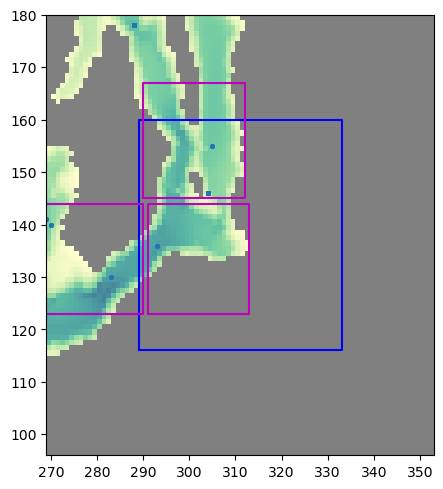

In [81]:
box_size = 22

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
Nooksack = river_box('fraser', 'Nooksack', box_size)
plot_box(ax, Nooksack, 'b')
Nooksack_E = make_poly4corn(290, 312, 335, 357)
Nooksack_W = make_poly4corn(290, 312, 313, 335)
plot_poly(ax, Nooksack_E, 'm')
plot_poly(ax, Nooksack_W, 'm')

Skagit = river_box('skagit', 'Skagit1', box_size)
plot_box(ax, Skagit, 'b')
Skagit_NE = make_poly4corn(205, 227, 300, 322)
Skagit_SE = make_poly4corn(180, 202, 295, 317)
Skagit_SW = make_poly4corn(190, 212, 272, 294)
plot_poly(ax, Skagit_NE, 'm')
plot_poly(ax, Skagit_SE, 'm')
plot_poly(ax, Skagit_SW, 'm')

Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
plot_box(ax, Snohomish, 'b')
Snohomish_NE = make_poly4corn(145, 167, 290, 312)
Snohomish_SE = make_poly4corn(123, 144, 291, 313)
Snohomish_SW = make_poly4corn(123, 144, 268, 290)
plot_poly(ax, Snohomish_NE, 'm')
plot_poly(ax, Snohomish_SE, 'm')
plot_poly(ax, Snohomish_SW, 'm')

Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
plot_box(ax, Nisqually, 'b')
Nisqually_c = make_poly4corn(10, 32, 120, 142)
plot_poly(ax, Nisqually_c, 'm')

Elwha = river_box('jdf', 'Elwha', box_size)
plot_box(ax, Elwha, 'b')

Cowichan = river_box('evi_s', 'Cowichan1', box_size)
plot_box(ax, Cowichan, 'b')

Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
plot_box(ax, Nanaimo, 'b')

Puntledge = river_box('evi_s', 'Puntledge', box_size)
plot_box(ax, Puntledge, 'b')

Salmon = river_box('evi_n', 'SalmonSayward', box_size)
plot_box(ax, Salmon, 'b')

Homathko = river_box('bute', 'Homathko', box_size)
plot_box(ax, Homathko, 'b')

Squamish = river_box('howe', 'Squamish', box_size)
plot_box(ax, Squamish, 'b')

boxes = [Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish, Skagit_NE, Skagit_SE, Skagit_SW]
boxnames = ['Nooksack', 'Skagit', 'Snohomish', 'Nisqually', 'Elwha', 'Cowichan', 'Nanaimo', 'Puntledge', 'Salmon', 'Homathko', 'Squamish', 'Skagit_NE', 'Skagit_SE', 'Skagit_SW']

polys = [Skagit_NE, Skagit_SE, Skagit_SW, Nooksack_E, Nooksack_W, Snohomish_NE, Snohomish_SE, Snohomish_SW, Nisqually_c]
polynames = ['Skagit_NE', 'Skagit_SE', 'Skagit_SW', 'Nooksack_E', 'Nooksack_W', 'Snohomish_NE', 'Snohomish_SE', 'Snohomish_SW', 'Nisqually_c']

ax.scatter(temp1['i'][temp1['k'] <= 17.5], temp1['j'][temp1['k'] <= 17.5], s=5)

focus = Snohomish
plt.ylim(focus[0]-20, focus[1]+20)
plt.xlim(focus[2]-20, focus[3]+20)

In [82]:
temp1.shape

(2895427, 60)

In [83]:
temp1['polygon']

0          udt
1          udt
2          udt
3          udt
4          udt
          ... 
2895422    udt
2895423    udt
2895424    udt
2895425    udt
2895426    udt
Name: polygon, Length: 2895427, dtype: object

In [84]:
temp1[temp1['polygon'] != None]

,Unnamed: 0,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,...,oxygen (uM),indf_ptrc_T,ih_ptrc_T,indf_grid_T,ih_grid_T,dtUTCfix,datetime,polygon,season,diff
0,0,2013.0,1,10.0,17.118056,49.329667,-124.081000,0.892338,27.814801,6.753649,...,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter,0.391980
1,1,2013.0,1,10.0,17.118056,49.329667,-124.081000,1.883821,27.826002,6.762110,...,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter,0.380791
2,2,2013.0,1,10.0,17.118056,49.329667,-124.081000,2.974446,27.842222,6.764341,...,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter,0.364620
3,3,2013.0,1,10.0,17.118056,49.329667,-124.081000,4.065065,27.901148,6.812357,...,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter,0.305905
4,4,2013.0,1,10.0,17.118056,49.329667,-124.081000,4.957386,28.036150,6.874438,...,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter,0.170902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895422,171184,NaN,10,NaN,NaN,49.171881,-123.630172,NaN,NaN,NaN,...,286.524975,287.0,23.0,287.0,23.0,2019-10-15 23:55:00,2019-10-15 23:55:00,udt,Fall,NaN
2895423,171185,NaN,10,NaN,NaN,49.174657,-123.637464,NaN,NaN,NaN,...,285.443224,287.0,23.0,287.0,23.0,2019-10-15 23:56:00,2019-10-15 23:56:00,udt,Fall,NaN
2895424,171186,NaN,10,NaN,NaN,49.177499,-123.644701,NaN,NaN,NaN,...,284.166118,287.0,23.0,287.0,23.0,2019-10-15 23:57:00,2019-10-15 23:57:00,udt,Fall,NaN
2895425,171187,NaN,10,NaN,NaN,49.180270,-123.652008,NaN,NaN,NaN,...,282.333631,287.0,23.0,287.0,23.0,2019-10-15 23:58:00,2019-10-15 23:58:00,udt,Fall,NaN


# Look deeper

In [85]:
def det_season(month):
    if month in (3, 4, 5):
        season = 'Spring'
    elif month in (6, 7, 8):
        season = 'Summer'
    elif month in (9, 10, 11):
        season = 'Fall'
    elif month in (12, 1, 2):
        season = 'Winter'
    else:
        print('error: not a month')
    return season

In [86]:
def det_spatial(x, y):
    point = shapely.geometry.Point(x,y)
    for idx in np.arange(len(polys)):
        poly = polys[idx]
        if poly.contains(point):
            return polynames[idx]
    else:
        return 'udt'
    

In [87]:
def plot_and_stats_season(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    # print (temp1[temp1.k <= idepth])
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    # print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts = 'placeholder'

    ax.scatter(select[one][select['season'] == 'Spring'], select[two][select['season'] == 'Spring'], c='g', s=5, label='Spring')
    ax.scatter(select[one][select['season'] == 'Summer'], select[two][select['season'] == 'Summer'], c='y', s=5, label='Summer')
    ax.scatter(select[one][select['season'] == 'Fall'], select[two][select['season'] == 'Fall'], c='r', s=5, label='Fall')
    ax.scatter(select[one][select['season'] == 'Winter'], select[two][select['season'] == 'Winter'], c='c', s=5, label='Winter')

    ax.legend()

   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    # dCp2 = pd.DataFrame(data=Cp2, index=[name])
    # return dCp2, counts

In [88]:
def plot_and_stats_poly(polys, polynames, temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    # print (temp1[temp1.k <= idepth])
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    # print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts = 'placeholder'

    colors = ['r', 'y', 'g', 'b']
    for idx in range(len(polys)):
        ax.scatter(select[one][select['polygon'] == polynames[idx]], select[two][select['polygon'] == polynames[idx]], c=colors[idx], s=5, label=polynames[idx])
    ax.legend()

   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    # dCp2 = pd.DataFrame(data=Cp2, index=[name])
    # return dCp2, counts

In [89]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])

    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)

    temp1['Month'] = [int(utc[5:7]) for utc in temp1['dtUTC'].values]
    temp1['dtUTCfix'] = [utc[0:19] for utc in temp1['dtUTC'].values]
    temp1['datetime'] = [datetime.datetime.strptime(utc[0:19], '%Y-%m-%d %H:%M:%S') for utc in temp1['dtUTC'].values]
    temp1['polygon'] = [det_spatial(i, j) for j, i in zip(temp1['j'].values, temp1['i'].values)]
    temp1['season'] = [det_season(mon) for mon in temp1['Month'].values]
    return temp1

In [90]:
def plot_profiles(temp1, temp2, ax3, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    kls = len(select.groupby('k')[obsn])

    counts = select.groupby(by='k').count()
    ax3.set_title('# Points per k')
    ax3.plot(counts['Month'], deptht[:kls])
    ax3.invert_yaxis()

In [91]:
def plot_points_in_regions(ax, temp1, box, polys, polynames):
    
    mycmap = cm.deep
    mycmap.set_bad('grey')
    ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    viz_tools.set_aspect(ax);

    ax.scatter(temp1['i'], temp1['j'], s=5)

    colors = ['r', 'y', 'g', 'b']
    for idx in range(len(polys)):
        plot_poly(ax, polys[idx], colors[idx])

    plot_box(ax, box, 'b')

    ax.set_ylim(box[0]-20, box[1]+20)
    ax.set_xlim(box[2]-20, box[3]+20)

In [92]:
def stats_and_plot_season(years, years_psf, years_pug, years_onc, years_ferry, years_cioos):
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv') 
    for year in years_cioos:
        if (year == 2023):
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}1231.csv')    
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    temp1 = read_pieces(pieces1)


    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_cioos:
        if (year == 2023):
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)

    return temp1, temp2

In [93]:
def do_the_plots(temp1, temp2, idepth, jdepth, box, boxname, polys, polynames, whichdepths):
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 8))
    fig.suptitle(f'{boxname} Year {temp1["Year"].min()}-{temp1["Year"].max()}')

    plot_and_stats_season(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0,0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    plot_and_stats_poly(polys, polynames, filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0,2], whichdepths, False, '', boxes=False, box=box, boxname=boxname)

    plot_and_stats_season(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[0,1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    plot_and_stats_poly(polys, polynames, filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[0,3], whichdepths, False, '', boxes=False, box=box, boxname=boxname)
    
    plot_profiles(temp1, temp2, axs[1,2], box, boxname)

    plot_points_in_regions(axs[1,3], temp1, box, polys, polynames)

    point = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=False)
    mycmap = cm.deep
    mycmap.set_bad('grey')
    axs[1,0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    axs[1,0].set_xlim(box[2]-20, box[3]+20)
    axs[1,0].set_ylim(box[0]-20, box[1]+20)
    axs[1,0].plot(point[1], point[0], 'r*', markersize=5)
    axs[1,0].set_title('bathy 202108')
    viz_tools.set_aspect(axs[1,0]);

    point2 = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=True)
    axs[1,1].pcolormesh(bathy2['Bathymetry'], cmap=mycmap)
    axs[1,1].set_ylim(box[0]-20, box[1]+20)
    axs[1,1].set_xlim(box[2]-20, box[3]+20)
    axs[1,1].plot(point2[1], point2[0], 'r*', markersize=5)
    axs[1,1].set_title('bathy 201702')
    viz_tools.set_aspect(axs[1,1]);

In [94]:
temp1, temp2 = stats_and_plot_season([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

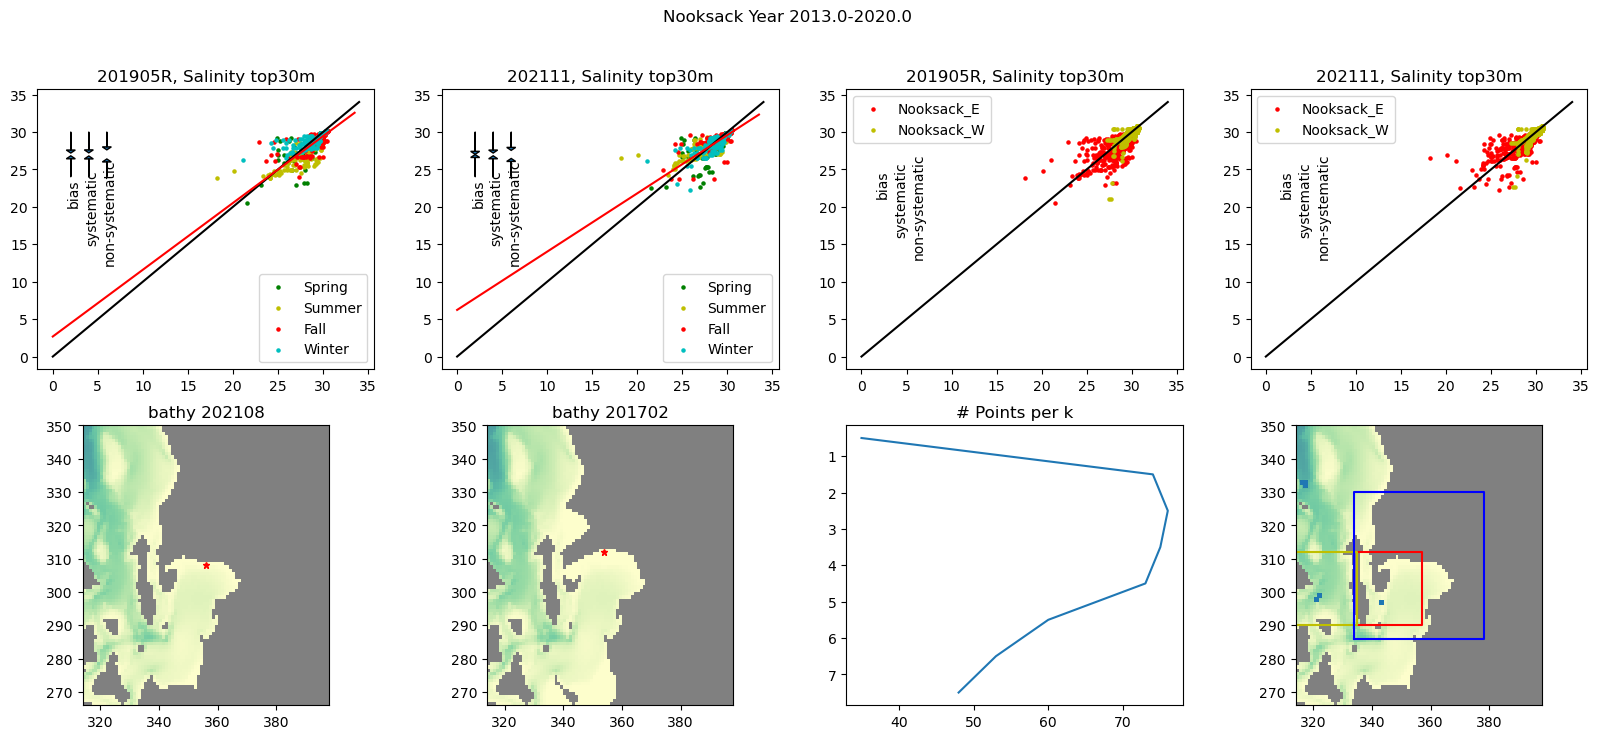

In [95]:
idepth = 0
jdepth = 30
region = 'Nooksack'
polys_sub = [Nooksack_E, Nooksack_W]
polynames_sub = ['Nooksack_E', 'Nooksack_W']

do_the_plots(temp1, temp2, idepth, jdepth, Nooksack, region, polys_sub, polynames_sub, 'top30m')

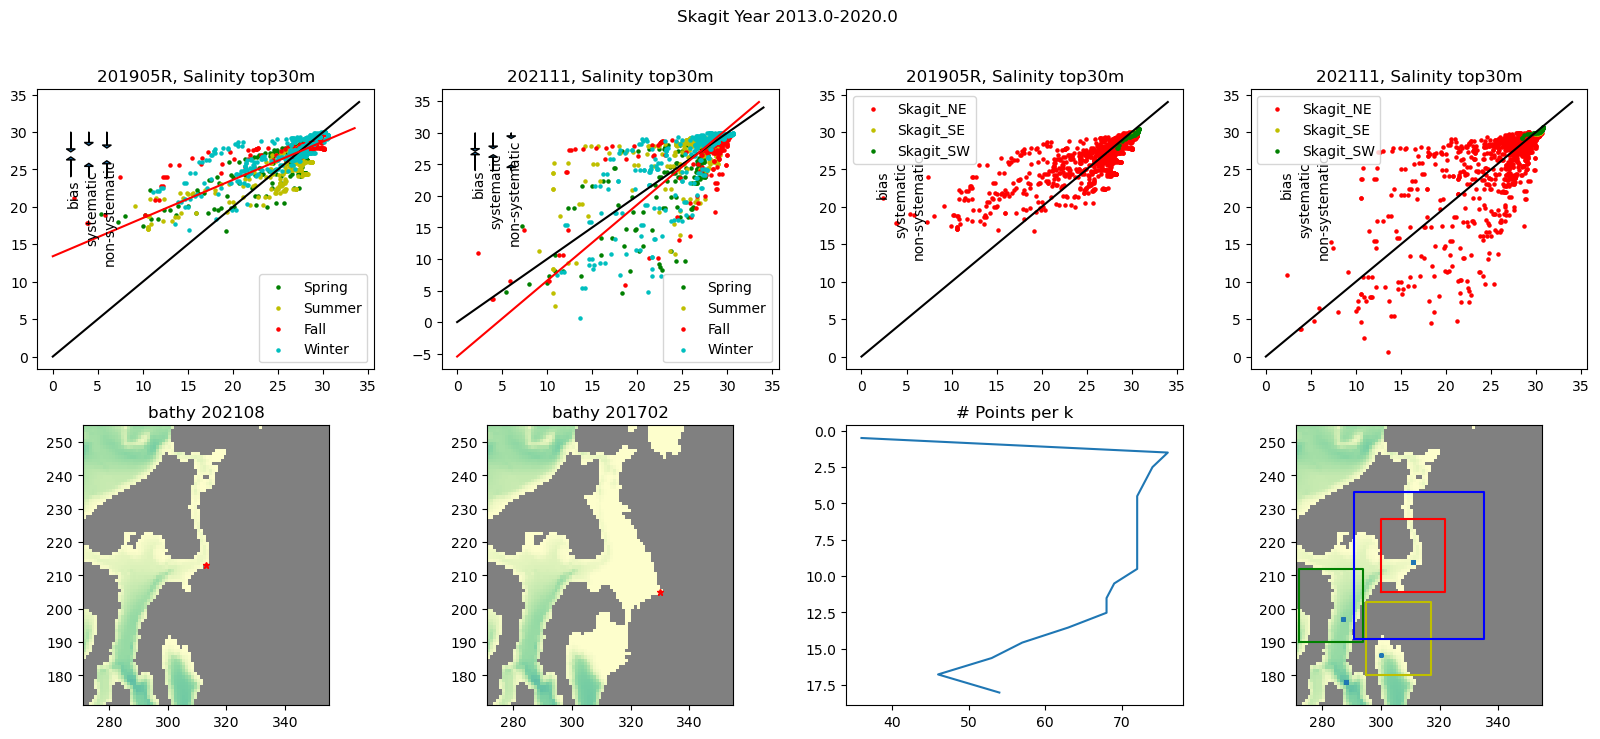

In [96]:
idepth = 0
jdepth = 30
region = 'Skagit'
polys_sub = [Skagit_NE, Skagit_SE, Skagit_SW]
polynames_sub = ['Skagit_NE', 'Skagit_SE', 'Skagit_SW']

do_the_plots(temp1, temp2, idepth, jdepth, Skagit, region, polys_sub, polynames_sub, 'top30m')

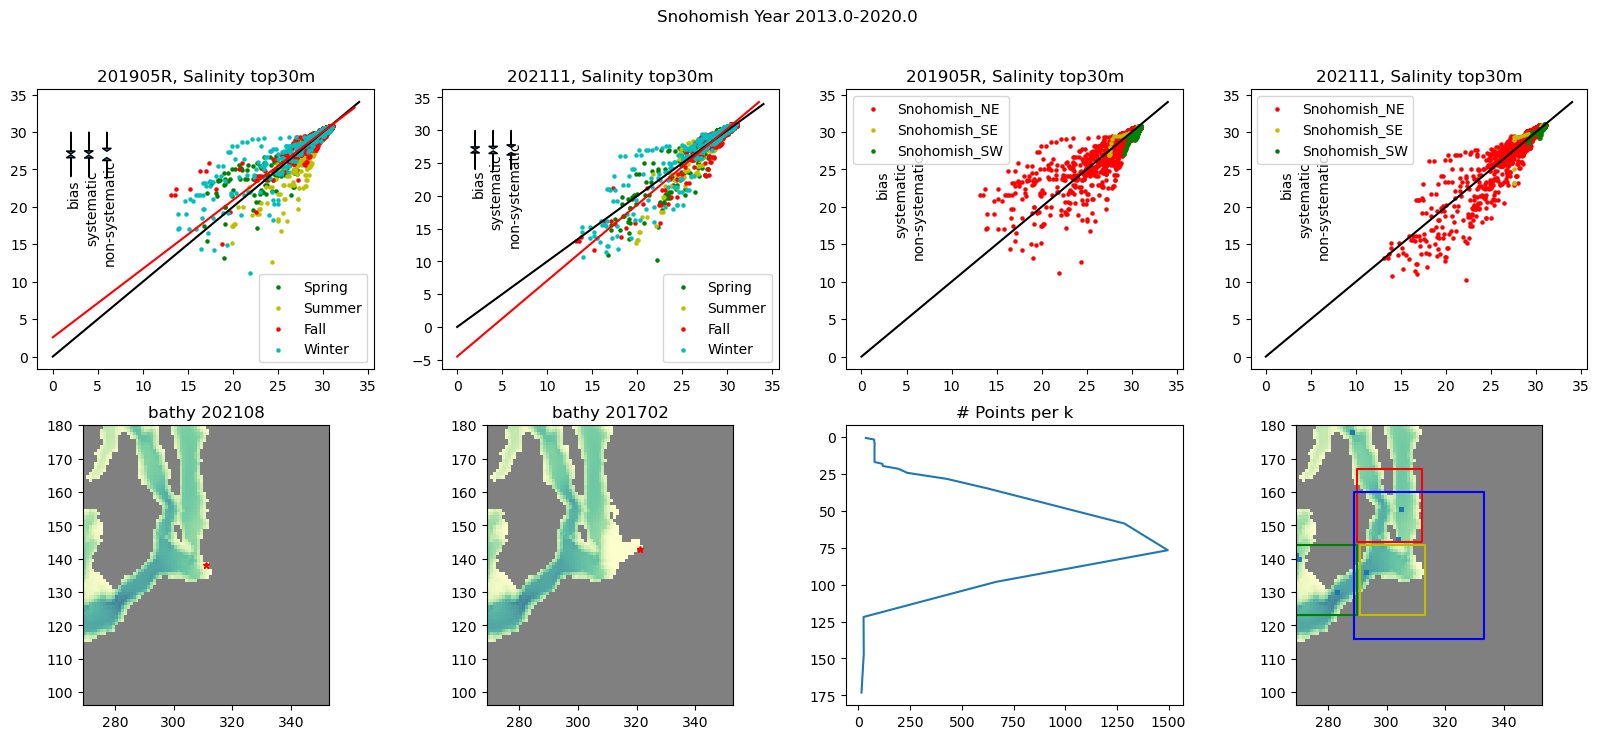

In [97]:
idepth = 0
jdepth = 30
region = 'Snohomish'
polys_sub = [Snohomish_NE, Snohomish_SE, Snohomish_SW]
polynames_sub = ['Snohomish_NE', 'Snohomish_SE', 'Snohomish_SW']

do_the_plots(temp1, temp2, idepth, jdepth, Snohomish, region, polys_sub, polynames_sub, 'top30m')

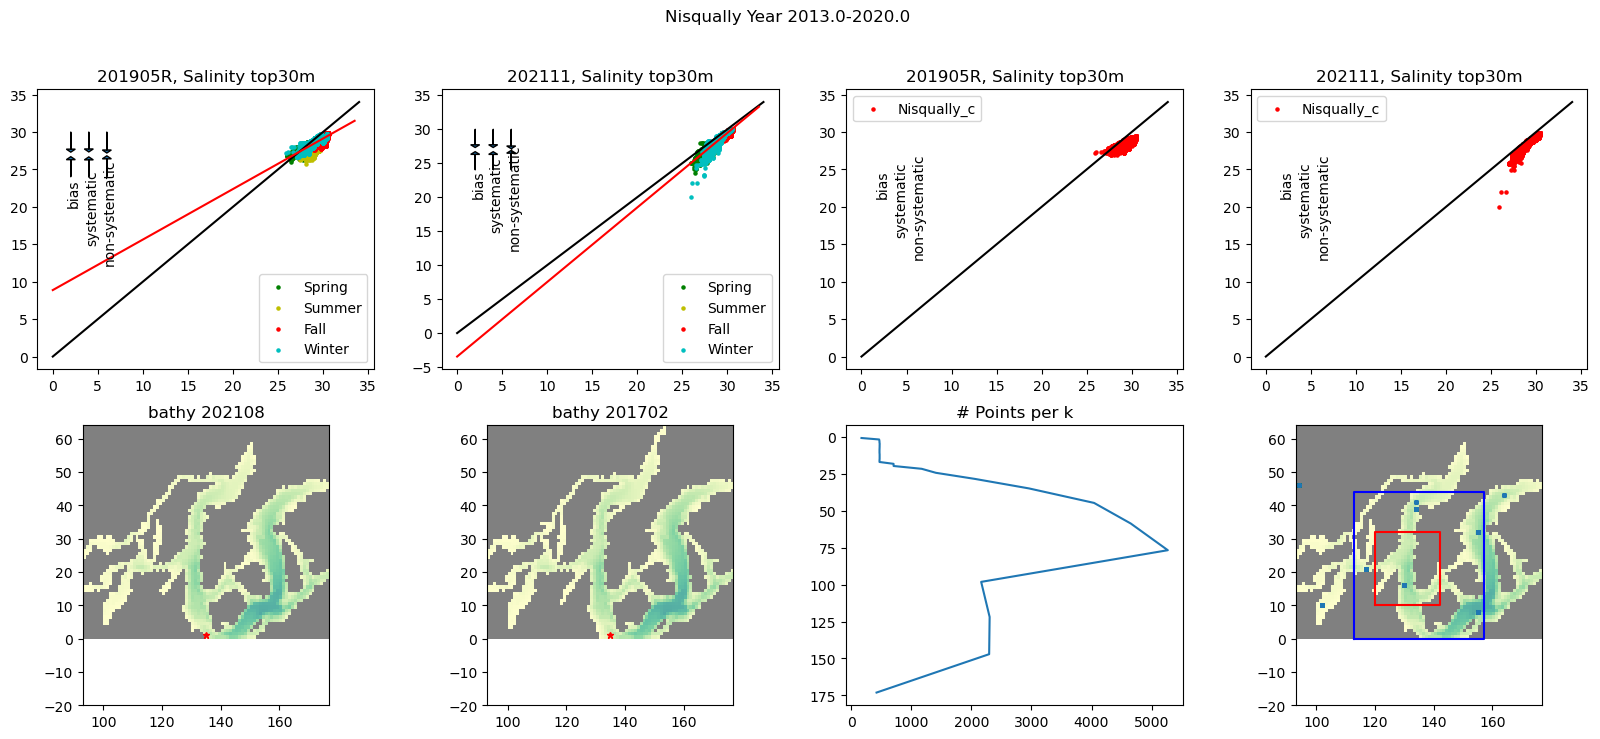

In [98]:
idepth = 0
jdepth = 30
region = 'Nisqually'
polys_sub = [Nisqually_c]
polynames_sub = ['Nisqually_c']

do_the_plots(temp1, temp2, idepth, jdepth, Nisqually, region, polys_sub, polynames_sub, 'top30m')

## Scratch

In [99]:
idepth = 0
jdepth = 10
region = 'Skagit'

years= [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
years_psf = [2015, 2016, 2017]
years_pug = [2015, 2016, 2017, 2018]
years_onc = [2015, 2016, 2017, 2018, 2019, 2020]
years_ferry = [2015, 2016, 2017, 2018, 2019]
years_cioos = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
box = Skagit
boxname = region
whichdepths = 'top30m'    

pieces1 = []
for year in years:
    pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
            )  # Year, Month, Day
for year in years_psf:
    pieces1.append(
        f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')  # 'dtUTC'
for year in years_pug:
    pieces1.append(
        f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')  # 'dtUTC'
for year in years_onc:
    pieces1.append(
        f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')  # 'dtUTC'
for year in years_cioos:
    if (year == 2023):
        pieces1.append(
            f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}0805.csv')  # 'dtUTC'
    else: 
        pieces1.append(
            f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}1231.csv')    
for year in years_ferry:
    pieces1.append(
        f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   # 'dtUTC'
temp1 = read_pieces(pieces1)

In [100]:
reverse=False
boxes=True

if boxes:
    corn = box
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                            (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                            (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    shift_text = 0.94
else:
    select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
    shift_text = 1

print (swillmott(select, 'SA', 'mod_vosaline'))

if reverse:
    one = modn
    two = obsn
else:
    one = obsn
    two = modn

select

0.2130702198215445


,Unnamed: 0,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,...,o2_concentration_corrected (ml/l),oxygen (uM),indf_ptrc_T,ih_ptrc_T,indf_grid_T,ih_grid_T,dtUTCfix,datetime,polygon,season
1382838,3480,NaN,1,NaN,NaN,48.296488,-122.489605,1.0,18.065027,7.979422,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-21 21:25:00,2015-01-21 21:25:00,Skagit_NE,Winter
1382839,3481,NaN,1,NaN,NaN,48.296488,-122.489605,1.5,19.898122,8.483985,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-21 21:25:00,2015-01-21 21:25:00,Skagit_NE,Winter
1382840,3482,NaN,1,NaN,NaN,48.296488,-122.489605,2.0,20.315915,8.591076,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-21 21:25:00,2015-01-21 21:25:00,Skagit_NE,Winter
1382841,3483,NaN,1,NaN,NaN,48.296488,-122.489605,2.5,20.451653,8.622203,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-21 21:25:00,2015-01-21 21:25:00,Skagit_NE,Winter
1382842,3484,NaN,1,NaN,NaN,48.296488,-122.489605,3.0,20.649087,8.665399,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-21 21:25:00,2015-01-21 21:25:00,Skagit_NE,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582442,50975,NaN,12,NaN,NaN,48.296488,-122.489605,9.0,27.925504,11.041421,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-04 17:28:00,2018-12-04 17:28:00,Skagit_NE,Winter
1582443,50976,NaN,12,NaN,NaN,48.296488,-122.489605,9.5,28.155788,11.109521,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-04 17:28:00,2018-12-04 17:28:00,Skagit_NE,Winter
1582444,50977,NaN,12,NaN,NaN,48.296488,-122.489605,10.0,28.546544,11.220724,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-04 17:28:00,2018-12-04 17:28:00,Skagit_NE,Winter
1582445,50978,NaN,12,NaN,NaN,48.296488,-122.489605,10.5,29.248703,11.414967,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-04 17:28:00,2018-12-04 17:28:00,Skagit_NE,Winter


/tmp/ipykernel_4038531/151859151.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(select[one][select['season'] == 'Spring'], select[two][select['season'] == 'Spring'], c='g', s=5, cmap=cmap, label='Spring')
/tmp/ipykernel_4038531/151859151.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(select[one][select['season'] == 'Summer'], select[two][select['season'] == 'Summer'], c='y', s=5, cmap=cmap, label='Summer')
/tmp/ipykernel_4038531/151859151.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(select[one][select['season'] == 'Fall'], select[two][select['season'] == 'Fall'], c='r', s=5, cmap=cmap, label='Fall')
/tmp/ipykernel_4038531/151859151.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(select[one][select['season'] == 'Winter'], 

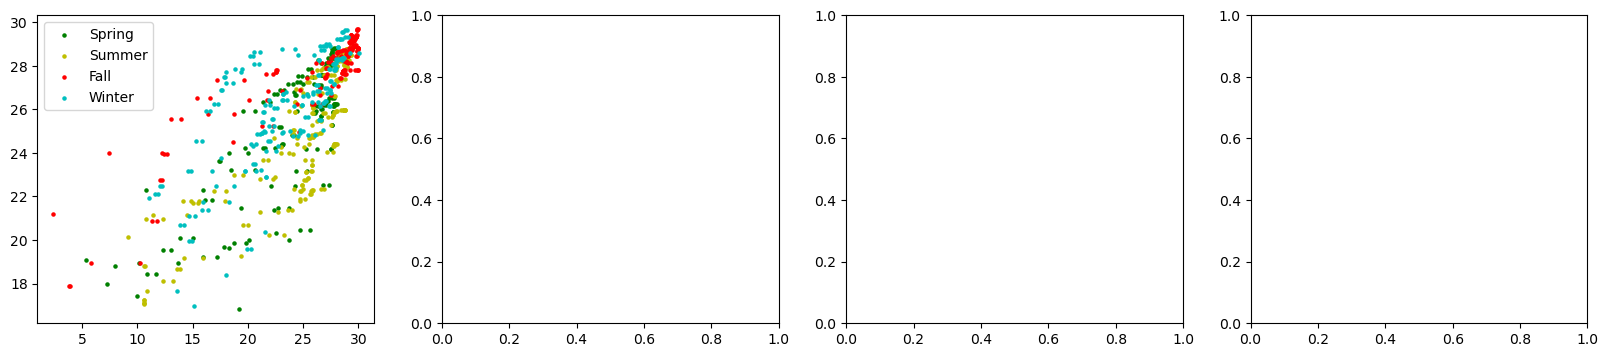

In [101]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

# cmap = cm.phase
cmap = plt.cm.Set1
# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # force the first color entry to be grey
# # cmaplist[0] = (.5, .5, .5, 1.0)

# # create the new map
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, cmap.N)

# # define the bins and normalize
# # bounds = np.linspace(1, 12, 13)
# bounds = np.linspace(1, 6, 6)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


# cb = axs[0].scatter(select[one], select[two], c=select['season'], s=5, cmap=cmap, norm=norm)
axs[0].scatter(select[one][select['season'] == 'Spring'], select[two][select['season'] == 'Spring'], c='g', s=5, cmap=cmap, label='Spring')
axs[0].scatter(select[one][select['season'] == 'Summer'], select[two][select['season'] == 'Summer'], c='y', s=5, cmap=cmap, label='Summer')
axs[0].scatter(select[one][select['season'] == 'Fall'], select[two][select['season'] == 'Fall'], c='r', s=5, cmap=cmap, label='Fall')
axs[0].scatter(select[one][select['season'] == 'Winter'], select[two][select['season'] == 'Winter'], c='c', s=5, cmap=cmap, label='Winter')

axs[0].legend()


# fig.colorbar(cb, ax=axs[0])


In [102]:
reverse=False
boxes=False

if boxes:
    corn = box
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                            (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                            (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    shift_text = 0.94
else:
    select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
    shift_text = 1

print (swillmott(select, 'SA', 'mod_vosaline'))

if reverse:
    one = modn
    two = obsn
else:
    one = obsn
    two = modn

select

0.097778121751041


,Unnamed: 0,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,...,o2_concentration_corrected (ml/l),oxygen (uM),indf_ptrc_T,ih_ptrc_T,indf_grid_T,ih_grid_T,dtUTCfix,datetime,polygon,season
0,0,2013.0,1,10.0,17.118056,49.329667,-124.081000,0.892338,27.814801,6.753649,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter
1,1,2013.0,1,10.0,17.118056,49.329667,-124.081000,1.883821,27.826002,6.762110,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter
2,2,2013.0,1,10.0,17.118056,49.329667,-124.081000,2.974446,27.842222,6.764341,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter
3,3,2013.0,1,10.0,17.118056,49.329667,-124.081000,4.065065,27.901148,6.812357,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter
4,4,2013.0,1,10.0,17.118056,49.329667,-124.081000,4.957386,28.036150,6.874438,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-10 17:07:05,2013-01-10 17:07:05,udt,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895422,171184,NaN,10,NaN,NaN,49.171881,-123.630172,NaN,NaN,NaN,...,6.415552,286.524975,287.0,23.0,287.0,23.0,2019-10-15 23:55:00,2019-10-15 23:55:00,udt,Fall
2895423,171185,NaN,10,NaN,NaN,49.174657,-123.637464,NaN,NaN,NaN,...,6.391331,285.443224,287.0,23.0,287.0,23.0,2019-10-15 23:56:00,2019-10-15 23:56:00,udt,Fall
2895424,171186,NaN,10,NaN,NaN,49.177499,-123.644701,NaN,NaN,NaN,...,6.362735,284.166118,287.0,23.0,287.0,23.0,2019-10-15 23:57:00,2019-10-15 23:57:00,udt,Fall
2895425,171187,NaN,10,NaN,NaN,49.180270,-123.652008,NaN,NaN,NaN,...,6.321704,282.333631,287.0,23.0,287.0,23.0,2019-10-15 23:58:00,2019-10-15 23:58:00,udt,Fall


/tmp/ipykernel_4038531/1983474511.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(select[one][select['polygon'] == 'Skagit_NE'], select[two][select['polygon'] == 'Skagit_NE'], s=5, cmap=cmap, label='Skagit_NE')
/tmp/ipykernel_4038531/1983474511.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(select[one][select['polygon'] == 'Skagit_SE'], select[two][select['polygon'] == 'Skagit_SE'], s=5, cmap=cmap, label='Skagit_SE')
/tmp/ipykernel_4038531/1983474511.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(select[one][select['polygon'] == 'Skagit_SW'], select[two][select['polygon'] == 'Skagit_SW'], s=5, cmap=cmap, label='Skagit_SW')
/tmp/ipykernel_4038531/1983474511.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(select[one][select['polyg

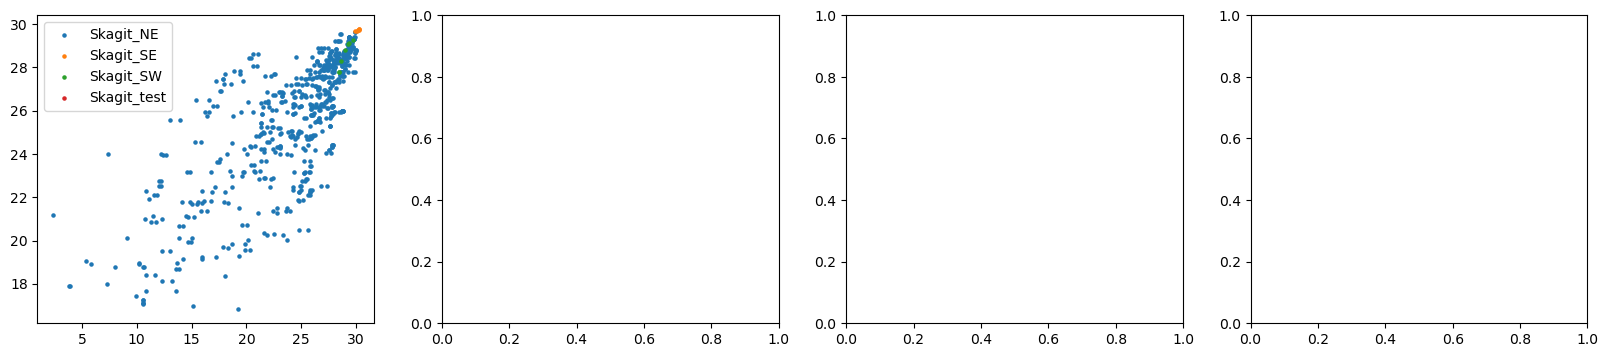

In [103]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

axs[0].scatter(select[one][select['polygon'] == 'Skagit_NE'], select[two][select['polygon'] == 'Skagit_NE'], s=5, cmap=cmap, label='Skagit_NE')
axs[0].scatter(select[one][select['polygon'] == 'Skagit_SE'], select[two][select['polygon'] == 'Skagit_SE'], s=5, cmap=cmap, label='Skagit_SE')
axs[0].scatter(select[one][select['polygon'] == 'Skagit_SW'], select[two][select['polygon'] == 'Skagit_SW'], s=5, cmap=cmap, label='Skagit_SW')
axs[0].scatter(select[one][select['polygon'] == 'Skagit_test'], select[two][select['polygon'] == 'Skagit_test'], s=5, cmap=cmap, label='Skagit_test')

axs[0].legend()

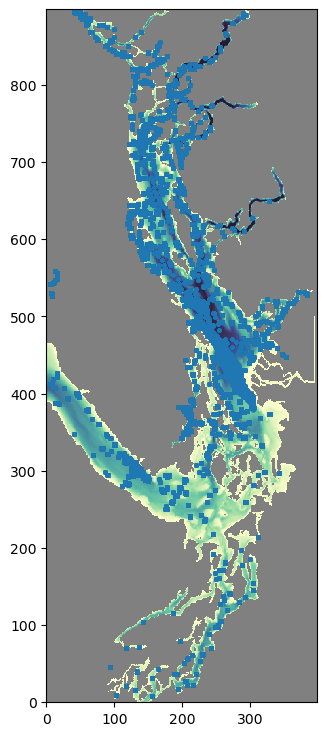

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

ax.scatter(temp1['i'], temp1['j'], s=5)

In [105]:
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

ax.scatter(temp1['i'], temp1['j'], s=5)

for poly in polys:
    plot_poly(ax, poly, 'm')

plot_box(ax, box, 'b')

ax.set_ylim(box[0]-20, box[1]+20)
ax.set_xlim(box[2]-20, box[3]+20)

(271.0, 355.0)

IndexError: list index out of range

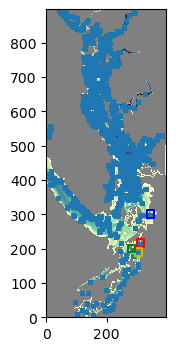

In [106]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
plot_points_in_regions(axs, temp1, Skagit, polys, polynames)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
ax[1].pcolormesh(bathy2['Bathymetry'], cmap=mycmap)

ax[0].set_ylim(Skagit[0]-20, Skagit[1]+20)
ax[0].set_xlim(Skagit[2]-20, Skagit[3]+20)

ax[1].set_ylim(Skagit[0]-20, Skagit[1]+20)
ax[1].set_xlim(Skagit[2]-20, Skagit[3]+20)

ax[0].set_title('bathy 202108')
ax[1].set_title('bathy 201702')

viz_tools.set_aspect(ax[0]);
viz_tools.set_aspect(ax[1]);